# Team Members

## RaviKiran Bhat

## Rubanraj Ravichandran

## Mohammad Wasil

## Ramesh Kumar

We will explore the use of Reinforcement Learning for a very simple problem: the k-armed bandits. Use the python tools of your preference (TensorFlow, scikit-learn, numpy, pandas, etc).

1.- Implement a simulation of the k-armed bandits environment, with a variable value of k (should be configurable) and random p_i probabilities to obtain a reward of 0 or 1 from pulling each machine. The probabilities should be different each time you instance the environment.

2.- Build an algorithm that implements one of the exploration strategies and run it for a specified amount of time on k=10 armed bandits. Gather the obtained rewards and use them to train a supervised model that estimates the value of pulling each of the k machines.

3.- Using the learned model, estimate a policy for the environment and execute it on the same environment (with the same probabilities). Report the obtained results.

4.- Repeat parts 2 and 3, but now automate it with code and vary k from 10 to 1000 in steps of 10/50 as appropriate (depending on computation availability), and report the if increasing the value of k makes the problem "harder", using several metrics like the normalized reward (total reward / k) or the number of times the algorithm fails to converge and produces bad results, or if the algorithm learns sub-optimal policies. For statistical stability, you might repeat each instance of using a value of k multiple times, with different probabilities in each run.

5.- Repeat part 4 but now interleave policy learning for a certain number of iterations, and then exploiting that policy during exploration in order to improve the model (like Q-Learning does). Does this actually improve the model, or it leads to premature convergence to a sub-optimal policy? Compare your results with the ones obtained in part 4.

6.- Comment on the failure cases and sub-optimal policies that you have observed during your experimentations.Remember that I expect a good report of results, not just concentrating on the code, but also on scientific analysis of your results and explanations. Remember to put labels in plot axes and legends.


In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/emwe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Define our bandits
class kArmedBandits(object):
    
    #initialize the number of bandits and actions randomly
    def initialize_bandits(self, num_bandits, num_actions):
        self.bandits = np.random.randn(num_bandits, num_actions)
        self.num_bandits = num_bandits
        self.num_actions = num_actions
    
    #choose bandit, get it randomly from the available ones
    def get_bandit(self):
        self.state = np.random.randint(0,len(self.bandits))
        return self.state
    
    #pull the arm, given action and return the reward
    def pull_arm(self, action):
        bandit = self.bandits[self.state, action]
        reward = self.get_reward(bandit)
        
        return reward
        
    def get_reward(self, bandit):
        random_numb = np.random.uniform(0, 1)
        if random_numb > bandit:
            return 1
        else:
            return 0
    
    #define the model (policy gradient which is the learned weights)
    #compute the reward and determine the action, and feed them into network
    #then compute the loss and update the network
    def set_policy_gradient(self):
        l_rate = 0.001
        state_size = self.num_bandits
        action_size = self.num_actions
        
        #self.weights = tf.trainable_variables()[0]
        self.state_in= tf.placeholder(shape=[1],dtype=tf.int32)
        state_in_OH = slim.one_hot_encoding(self.state_in, state_size)
        output = slim.fully_connected(state_in_OH, action_size,\
                    biases_initializer=None, activation_fn=tf.nn.sigmoid,
                    weights_initializer=tf.zeros_initializer())
        self.output = tf.reshape(output,[-1])
        self.chosen_action = tf.argmax(self.output,0)

        #Feed the reward and the chosen action into the NN
        #Compute the loss and update the model
        self.reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
        self.responsible_weight = tf.slice(self.output,self.action_holder,[1])
        self.loss = -(tf.log(self.responsible_weight)*self.reward_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=l_rate)
        self.update = optimizer.minimize(self.loss)
    
    def train(self, epsilon_greedy, num_episodes, exploitation=False):
        tf.reset_default_graph()
        
        self.set_policy_gradient()
        weights = tf.trainable_variables()[0]
        total_reward = np.zeros([self.num_bandits, self.num_actions])
        
        total_values = np.zeros([self.num_bandits, self.num_actions])
                
        init = tf.initialize_all_variables()
        
        self.avg_rewards = []
        self.avg_values = []
        
        with tf.Session() as sess:
            sess.run(init)
            for i in range(num_episodes):
                #Get the current state
                curr_state = self.get_bandit()

                if exploitation:       
                    #explore or exploit
                    if np.random.uniform(0, 1) < epsilon_greedy:
                        action = np.random.randint(self.num_actions)
                    else:
                        action = sess.run(self.chosen_action, feed_dict={self.state_in:[curr_state]})
                else:
                    action = np.random.randint(self.num_actions)
                
                #get reward given action
                reward = self.pull_arm(action)

                #update the model or network
                feed_dict={self.reward_holder:[reward], self.action_holder:[action], self.state_in:[curr_state]}
                _, self.values = sess.run([self.update,weights], feed_dict=feed_dict)

                #update the rewards for this action
                total_reward[curr_state, action] += reward
                
                #self.values = np.asarray(self.values)
                total_values[curr_state, action] = self.values[curr_state, action]
                #print (self.values.shape)
                if i % 100 == 0:
                    self.avg_rewards.append(np.mean(total_reward, axis=1))
                    self.avg_values.append(np.mean(total_values, axis=1))
                    
        
        self.listof_true = 0
        self.listof_false = 0
        for a in range(self.num_bandits):
            #does the weight correspond to the min bandit action
            if np.argmax(self.values[a]) == np.argmin(self.bandits[a]):
                self.listof_true += 1
            else:
                self.listof_false += 1
    

In [14]:
def run(k, num_actions, epsilon_greedy, episodes, exploitation):
    kAB = kArmedBandits()
    kAB.initialize_bandits(k,num_actions)
    kAB.set_policy_gradient()
    kAB.train(epsilon_greedy, episodes, exploitation)
    avg_rewards = np.asarray(kAB.avg_rewards)
    pos_percentage = kAB.listof_true / kAB.num_bandits
    neg_percentage = kAB.listof_false / kAB.num_bandits
    return avg_rewards, pos_percentage, neg_percentage

In [15]:
def experiment(k, num_actions, epsilon_greedy, episodes, exploitation=False):
    all_pos_percentage = []
    all_neg_percentage = []

    for i in range(len(k)):
        avg_rewards, pos_percentage, neg_percentage = run(k[i], num_actions, epsilon_greedy, episodes, exploitation=exploitation)
        all_pos_percentage.append(pos_percentage)
        all_neg_percentage.append(neg_percentage)
        for j in range(k[i]):
            plt.subplot(2, 3, i+1)
            plt.plot(avg_rewards[:,j])
            plt.ylabel('Rewards')
            plt.xlabel("Step")
            plt.subplots_adjust(top = 0.6, bottom=0.01, hspace=0.4, wspace=0.4)

            plt.title('Rewards with k='+str(k[i]))
        #plt.legend()
    return all_pos_percentage, all_neg_percentage

In [17]:
#set parameters
k = [2, 4, 6, 10, 12]
num_actions = 6
epsilon_greedy = 0.1
episodes = 1000

# 4. Experiment with exploration only

/home/emwe/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


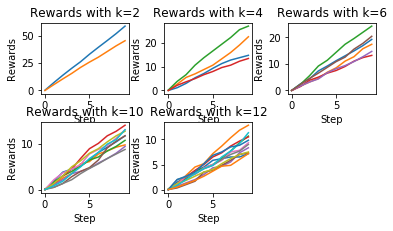

In [43]:
#Number 4, experiment without exploitation
positive_percentage, negative_percentage = experiment(k, num_actions, epsilon_greedy, episodes, exploitation=False)

Text(0.5,0,'k')

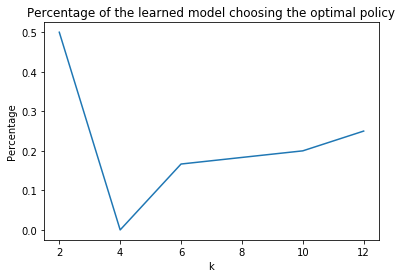

In [44]:
#With the learned model, we can see result of choosing the right and wrong action
plt.plot(k, positive_percentage)
plt.title("Percentage of the learned model choosing the optimal policy")
plt.ylabel("Percentage")
plt.xlabel("k")

Text(0.5,0,'k')

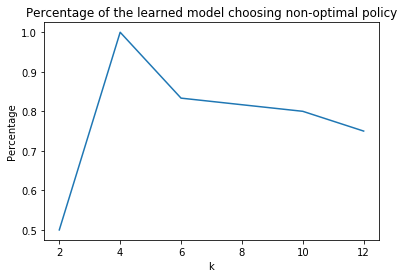

In [45]:
plt.plot(k, negative_percentage)
plt.title("Percentage of the learned model choosing non-optimal policy")
plt.ylabel("Percentage")
plt.xlabel("k")

If we increase the number k, the algorithm tends to go with non optimal policy, as we can see from the plot the positive percentage where the predicted values match the optimal ones is decreased because the number k increses. On the other hand, the negative percentage increased.

# 5. Experiment with exploration and exploitation

/home/emwe/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


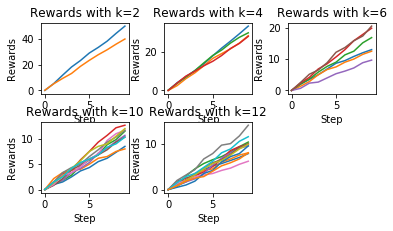

In [47]:
#Number 5, experiment with exploration and exploitation
positive_percentage, negative_percentage = experiment(k, num_actions, epsilon_greedy, episodes, exploitation=False)

Text(0.5,0,'k')

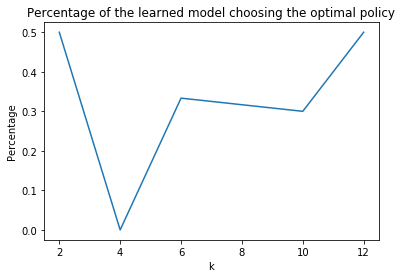

In [48]:
#With the learned model, we can see result of choosing the right and wrong action
plt.plot(k, positive_percentage)
plt.title("Percentage of the learned model choosing the optimal policy")
plt.ylabel("Percentage")
plt.xlabel("k")

Text(0.5,0,'k')

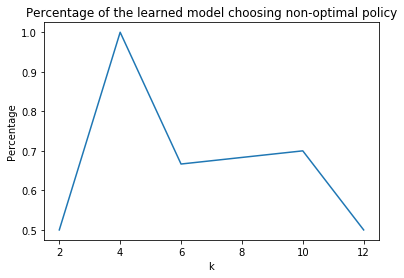

In [49]:
plt.plot(k, negative_percentage)
plt.title("Percentage of the learned model choosing non-optimal policy")
plt.ylabel("Percentage")
plt.xlabel("k")

Combination of exploration and exploitation do help the performance, increasing the number of k does not necessarily decrease the positive value. Instead, it increased while the negative value decreased.

* Positive value here means that the algorithm tends to choose the optimal policy, while negative value means that the algorithm then to choose non optimal policy.

Overall, the performance increased when we combined the exploration and exploitation with greedy epsilon 0.1.